In [ ]:
!pip install yfinance

In [ ]:
!pip install langchain_google_genai langgraph langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requ

In [ ]:
!pip install newsapi-python

In [ ]:
!pip install sec-api

This cell imports the necessary libraries for the project: `yfinance` for fetching stock data, `langchain_google_genai` for using the Google Generative AI models with Langchain, `json` for working with JSON data, `typing` for type hinting, and `langgraph` for building the agent graph.

In [ ]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
import json
import yfinance as yf
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, END, START
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

This cell retrieves the secret API keys for Gemini, News API, and SEC API from the Colab user data. These keys are necessary to authenticate and use the respective services.

In [ ]:
# Retrieve the secret key
gemini_api_key=userdata.get("GEMINI_API_KEY")
news_api=userdata.get("NewsApi")
sec_api=userdata.get("SecAPI")


This cell initializes the `ChatGoogleGenerativeAI` model from Langchain, specifying the model name (`gemini-2.5-flash-lite`), temperature, and providing the Gemini API key. This `llm` object will be used for generating text and parsing outputs in the agents.

In [ ]:
## LLM for our project
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite', temperature=0.2, api_key=gemini_api_key)


## Define State

This cell defines the `ResearchState` TypedDict, which represents the state of our research agent. It includes fields to store the stock symbol, company profile, research plan, retrieved data, draft report, critique, final report, run memory, and evaluation count.

In [ ]:

class ResearchState(TypedDict):
    stock_symbol: str           # The input stock symbol
    company_profile: Dict       # To hold sector, industry, summary
    research_plan: List[str]    # The plan generated by the Planner Agent
    retrieved_data: Dict        # A dictionary to store data from tools (news, financials, etc.)
    draft_report: str           # The initial analysis/report
    critique: str               # Feedback from the Evaluator Agent
    final_report: str           # The polished, final report
    evaluation_count: int       # To limit evaluation-generation loop

## Tools


### News Tool

This cell defines the `fetch_news` tool using the `@tool` decorator from `langchain_core.tools`.

This tool fetches recent news articles for a given stock symbol using the News API and returns a formatted string of the top 5 articles.

In [ ]:
from langchain_core.tools import tool
from newsapi import NewsApiClient
# Init
newsapi = NewsApiClient(api_key=news_api)

@tool
def fetch_news(stock_symbol: str) -> str:
    """
    Orchestrates news chaining: Ingest → Preprocess → Classify → Extract → Summarize.
    Calls modular sub-functions for each step.
    """
    try:
        # Step 1: Ingest - Fetch raw articles
        articles_response = newsapi.get_everything(
            q=f'"{stock_symbol}"',
            language='en',
            sort_by='relevancy',
            page_size=5
        )
        articles = articles_response['articles']
        if not articles:
            return f"No relevant news found for {stock_symbol}."

        print(f"---CHAINING NEWS FOR {stock_symbol} (Ingested {len(articles)} articles)---")

        # Step 2: Preprocess
        raw_texts = preprocess_articles(articles)

        # Step 3: Classify
        articles_list = [{"title": text.split('\n')[0].replace("Title: ", ""), "content": text.split('Content: ')[1]} for text in raw_texts if '\n' in text]
        sentiments = classify_sentiments(stock_symbol, articles_list)

        # Step 4: Extract
        entities = extract_entities(raw_texts)

        # Step 5: Summarize
        summary = summarize_insights(stock_symbol, sentiments, entities)

        # Format final output
        preprocessed_text = "\n\n---\n\n".join(raw_texts)
        chained_output = f"""--- Chained News Analysis for {stock_symbol} ---

        **Sentiments (per article):**
        {json.dumps(sentiments, indent=2)}

        **Extracted Entities:**
        {json.dumps(entities, indent=2)}

        **Summary Insights:**
        {summary}

        **Raw Preprocessed Texts (for reference):**
        {preprocessed_text[:500]}..."""

        return chained_output.strip()

    except Exception as e:
        print(f"--- Chain Error Details: {e} ---")
        return f"Error in news chaining for {stock_symbol}: {e}"

# Test news chaining
# news_result = fetch_news.invoke("NVDA")
# print(news_result)

In [ ]:
# --- Sub-Functions for News Chaining (Modular Steps) ---
def preprocess_articles(articles: List[Dict]) -> List[str]:
    """
    Step 2: Preprocess - Clean and extract texts from raw articles.
    Returns list of formatted strings for chaining.
    """
    try:
        raw_texts = []
        for article in articles:
            title = article.get('title', 'N/A')
            description = (article.get('description', '') or 'No content available.')[:250]
            raw_texts.append(f"Title: {title}\nContent: {description}")
        print("--- Preprocessed: Extracted texts from articles ---")
        return raw_texts
    except Exception as e:
        print(f"--- Preprocess Error: {e} ---")
        return []

In [ ]:
def classify_sentiments(stock_symbol: str, articles_list: List[Dict]) -> List[Dict]:
    """
    Step 3: Classify - LLM chain for sentiment per article.
    Returns list of dicts: [{'title': ..., 'sentiment': 'bullish'}]
    """
    try:
        class_template = """Classify sentiment of each article as 'bullish', 'bearish', or 'neutral' for {stock_symbol}.
        Articles: {articles}

        Output ONLY valid JSON: {{"articles": [{{"title": "title1", "sentiment": "bullish"}}, ...]}}. No extra text."""
        class_prompt = ChatPromptTemplate.from_template(class_template)
        class_chain = class_prompt | llm | JsonOutputParser()
        sentiments_json = class_chain.invoke({
            "stock_symbol": stock_symbol,
            "articles": json.dumps(articles_list, indent=2)
        })
        sentiments = sentiments_json.get('articles', [])
        print(f"--- Classified: {len(sentiments)} sentiments (e.g., {sentiments[0]['sentiment'] if sentiments else 'None'}) ---")
        return sentiments
    except Exception as e:
        print(f"--- Classify Error: {e} ---")
        return []

In [ ]:
def extract_entities(raw_texts: List[str]) -> List[Dict]:
    """
    Step 4: Extract - LLM chain for key financial entities per text.
    Returns list of dicts: [{'title': ..., 'entities': ['AI growth', 'China ban']}]
    """
    try:
        texts_joined = "\n\n".join(raw_texts)
        extract_template = """Extract key financial entities (e.g., 'earnings beat', 'China ban', 'AI growth') from texts: {texts}.
        Output ONLY valid JSON: {{"articles": [{{"title": "Title1", "entities": ["entity1"]}}, ...]}}. No extra text."""
        extract_prompt = ChatPromptTemplate.from_template(extract_template)
        extract_chain = extract_prompt | llm | JsonOutputParser()
        entities_json = extract_chain.invoke({"texts": texts_joined})
        entities = entities_json.get('articles', [])
        print(f"--- Extracted: Entities from {len(entities)} items ---")
        return entities
    except Exception as e:
        print(f"--- Extract Error: {e} ---")
        return []

In [ ]:
def summarize_insights(stock_symbol: str, sentiments: List[Dict], entities: List[Dict]) -> str:
    """
    Step 5: Summarize - LLM chain for top insights.
    Returns bullet-point string.
    """
    try:
        sum_template = """Summarize top 3-5 insights for {stock_symbol} from sentiments: {sentiments} and entities: {entities}.
        Focus on trends, risks, opportunities. Output as bullet points—no JSON."""
        sum_prompt = ChatPromptTemplate.from_template(sum_template)
        sum_chain = sum_prompt | llm | StrOutputParser()
        summary = sum_chain.invoke({
            "stock_symbol": stock_symbol,
            "sentiments": json.dumps(sentiments, indent=2),
            "entities": json.dumps(entities, indent=2)
        })
        print("--- Summarized: Generated insights ---")
        return summary
    except Exception as e:
        print(f"--- Summarize Error: {e} ---")
        return "Summary unavailable due to error."

This cell defines the `fetch_financials` tool, which uses the `yfinance` library to fetch key financial data (Total Revenue, Net Income, Total Assets, Total Liabilities) from the most recent annual income statement and balance sheet for a given stock symbol.

### Finance Tool

In [ ]:
@tool
def fetch_financials(stock_symbol: str) -> str:
    """
    Fetches key financial data from the most recent annual Income Statement
    and Balance Sheet for a given stock symbol.
    """
    try:
        ticker = yf.Ticker(stock_symbol)

        # Get the most recent annual data
        income_stmt = ticker.financials
        balance_sheet = ticker.balance_sheet

        if income_stmt.empty or balance_sheet.empty:
            return f"Could not retrieve financial data for {stock_symbol}. It may be a delisted or invalid ticker."

        # Select the most recent year's column
        latest_year_income = income_stmt.iloc[:, 0]
        latest_year_balance = balance_sheet.iloc[:, 0]

        # Extract key metrics, using .get() for safety
        total_revenue = latest_year_income.get('Total Revenue', 'N/A')
        net_income = latest_year_income.get('Net Income', 'N/A')
        total_assets = latest_year_balance.get('Total Assets', 'N/A')
        total_liabilities = latest_year_balance.get('Total Liabilities Net Minority Interest', 'N/A')

        # Format everything into a clean string for the LLM
        # Using a helper to format numbers makes it more readable
        def format_currency(value):
            if isinstance(value, (int, float)):
                return f"${value:,.0f}"
            return "N/A"

        report = f"""--- Key Financials for {stock_symbol} (Most Recent Year) ---

        **Income Statement:**
        - Total Revenue: {format_currency(total_revenue)}
        - Net Income: {format_currency(net_income)}

        **Balance Sheet:**
        - Total Assets: {format_currency(total_assets)}
        - Total Liabilities: {format_currency(total_liabilities)}
        """
        return report.strip()

    except Exception as e:
        return f"An error occurred while fetching financials for {stock_symbol}: {e}"

# --- Example Usage ---
# print(fetch_financials.invoke("NVDA"))

This cell defines the `fetch_sec_filings` tool. This tool uses the SEC API to find the latest 10-K filing for a stock, extract the 'Risk Factors' and 'Management\'s Discussion and Analysis' sections, and provide a concise summary of both. It utilizes the `llm` to summarize the extracted text.

### SEC Tool

In [ ]:
from sec_api import QueryApi, ExtractorApi
queryApi = QueryApi(api_key=sec_api)
extractorApi = ExtractorApi(api_key=sec_api)

@tool
def fetch_sec_filings(stock_symbol: str) -> str:
    """
    Finds the latest 10-K filing for a stock, extracts the 'Risk Factors'
    and 'Management's Discussion and Analysis' sections, and returns
    a concise summary of both.
    """
    try:
        # --- STEP 1: Find the latest 10-K filing URL ---
        query = {
          "query": { "query_string": { "query": f'ticker:"{stock_symbol}" AND formType:"10-K"' }},
          "from": "0",
          "size": "1",
          "sort": [{ "filedAt": { "order": "desc" }}]
        }
        filings = queryApi.get_filings(query)

        if not filings['filings']:
            return f"No recent 10-K filings found for {stock_symbol}."

        # Get the URL of the filing
        filing_url=filings['filings'][0]['linkToFilingDetails']

        # --- STEP 2: Extract the sections using the Extractor API ---
        # Get Item 1A: Risk Factors
        risk_factors_text = extractorApi.get_section(
            filing_url=filing_url,
            section="1A", # The item code for Risk Factors
            return_type="text"
        )

        # Get Item 7: Management's Discussion and Analysis
        mda_text = extractorApi.get_section(
            filing_url=filing_url,
            section="7", # The item code for MD&A
            return_type="text"
        )

        # --- STEP 3: Summarize the extracted text ---
        template="Summarize the key takeaways from this text in 5 bullet points:\n\n{text}"
        prompt = ChatPromptTemplate.from_template(template)
        chain = prompt | llm | StrOutputParser()
        risk_summary = chain.invoke({"text": risk_factors_text})
        mda_summary = chain.invoke({"text": mda_text})
        summary = f'''The 'Risk Factors' summary is: {risk_summary} and \n\n
        "Management's Discussion and Analysis" summary is: {mda_summary}'''

        return summary.strip()

    except Exception as e:
        return f"An error occurred while fetching or processing SEC filings for {stock_symbol}: {e}"

# --- Example Usage ---
# Make sure your SEC_API_KEY is set as an environment variable
# print(fetch_sec_filings.invoke("AAPL"))

This cell defines the `fetch_market_data` tool, which fetches key market performance data, including the most recent analyst recommendations for a given stock symbol using `yfinance`.

### Market Tool

In [ ]:
@tool
def fetch_market_data(stock_symbol: str) -> str:
    """
    Fetches key market performance data, including the most recent analyst recommendations
    for a given stock symbol.
    """
    try:
        ticker = yf.Ticker(stock_symbol)
        info = ticker.info

        # A simple check for valid data. If a ticker is invalid, info is often missing keys.
        if not info or info.get('marketCap') is None:
             return f"Could not retrieve market data for {stock_symbol}. It may be a delisted or invalid ticker."

        # Get key market metrics
        fifty_two_week_high = info.get('fiftyTwoWeekHigh', 'N/A')  # Highest price the stock has traded at over the last 52 weeks
        fifty_two_week_low = info.get('fiftyTwoWeekLow', 'N/A')  # Lowest price the stock has traded at over the past 52 weeks
        market_cap = info.get('marketCap', 'N/A') # Total company valuation
        beta = info.get('beta', 'N/A') # Volatility vs. market (Beta measures how much a stock's price moves compared to the overall market.)

        # --- ANALYST RECOMMENDATIONS ---
        recs = ticker.recommendations
        analyst_consensus = "N/A" # Default value

        if recs is not None and not recs.empty:
            # Get only the most recent ratings (the first row of the DataFrame)
            most_recent_ratings = recs.iloc[0] # for the latest data

            # Safely get values using .get(), defaulting to 0 if a category is missing
            buy_ratings = most_recent_ratings.get('strongBuy', 0) + most_recent_ratings.get('buy', 0)
            total_ratings = most_recent_ratings.get('strongBuy', 0) + most_recent_ratings.get('buy', 0) + \
                            most_recent_ratings.get('hold', 0) + most_recent_ratings.get('sell', 0) + \
                            most_recent_ratings.get('strongSell', 0)

            if total_ratings > 0:
                analyst_consensus = f"{buy_ratings} of the {total_ratings} most recent analyst ratings are 'Buy' or 'Strong Buy'."

        # Helper function to format large numbers for better readability
        def format_large_number(value):
            if isinstance(value, (int, float)):
                if value > 1_000_000_000_000:
                    return f"${value/1_000_000_000_000:.2f} T"
                elif value > 1_000_000_000:
                    return f"${value/1_000_000_000:.2f} B"
                elif value > 1_000_000:
                    return f"${value/1_000_000:.2f} M"
                return f"${value:,.2f}"
            return "N/A"

        # Assemble the final report string
        report = f"""--- Market Data Snapshot for {stock_symbol} ---

**Performance & Valuation:**
- Market Cap: {format_large_number(market_cap)}
- 52-Week Range: {format_large_number(fifty_two_week_low)} - {format_large_number(fifty_two_week_high)}
- Beta (Volatility vs. Market): {beta}

**Analyst Sentiment:**
- Consensus: {analyst_consensus}
        """
        return report.strip()

    except Exception as e:
        return f"An error occurred while fetching market data for {stock_symbol}: {e}"

# --- Example Usage ---
# print(fetch_market_data.invoke("NVDA"))
# print(fetch_market_data.invoke("DUK"))

## Agents

This cell defines the `profiler_agent` function, which acts as a node in the LangGraph. It takes the current state as input, extracts the stock symbol, and uses `yfinance` to fetch a high-level company profile (sector, industry, and a truncated business summary). It updates the state with the company profile and initializes the evaluation count.

In [ ]:
# Profiler Node
def profiler_agent(state: ResearchState):
    """Fetches a high-level company profile."""
    print("---PROFILING COMPANY---")
    stock_symbol = state['stock_symbol']
    print(f"Profiler agent: Processing symbol {stock_symbol}")

    ticker = yf.Ticker(stock_symbol)
    profile = {
        "sector": ticker.info.get('sector', 'N/A'),
        "industry": ticker.info.get('industry', 'N/A'),
        "summary": ticker.info.get('longBusinessSummary', 'N/A')[:500] # Truncate for prompt
    }
    print(f"Profiler agent: Fetched profile for {stock_symbol}")

    return {"company_profile": profile, "evaluation_count": 0}

This cell defines the `planner_agent` function, another node in the LangGraph. It takes the current state, extracts the company profile, and uses the `llm` with a specific prompt to generate a prioritized research plan based on the company's sector, industry, and summary. The plan is output as a JSON formatted list of strings and updates the state.

In [ ]:
# Planner Node
def planner_agent(state: ResearchState):
    """Generates a research plan based on the company profile."""
    print("---CREATING DYNAMIC PLAN---")
    profile = state['company_profile']
    stock_symbol = state['stock_symbol']
    print(f"Planner agent: Creating plan for {stock_symbol} based on profile.")

    template = """
    You are a senior investment analyst. Based on the following company profile, create a prioritized, step-by-step research plan.
    Available steps are: 'fetch_news', 'fetch_financials', 'fetch_sec_filings', 'fetch_market_data'.

    Company Profile:
    - Sector: {sector}
    - Industry: {industry}
    - Summary: {summary}

    For a company in this sector and industry, what are the most critical research steps to take?
    For example, for a fast-moving tech company, news might be more critical than for a stable utility company.

    Output your plan as a JSON formatted list of strings.
    """
    prompt = ChatPromptTemplate.from_template(template)
    # ... (LLM call and parsing logic)
    chain = prompt | llm | JsonOutputParser()
    response = chain.invoke({
              "sector": profile["sector"],
              "industry": profile["industry"],
              "summary": profile["summary"]
          })
    print(f"Planner agent: Generated plan: {response}")

    return {"research_plan": response}

This cell initializes a `StateGraph` with the defined `ResearchState`. This graph will be used to define the workflow of our research agent (this is just an example, complete workflow is defined after other nodes are developed).  

In [ ]:
graph=StateGraph(ResearchState)

This cell adds the `profiler` and `planner` nodes to the graph. It sets the `profiler` as the entry point and adds an edge from `profiler` to `planner` and from `planner` to `END`, creating a simple initial graph. It then compiles the graph.

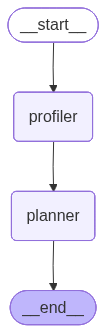

In [ ]:
graph.add_node('profiler', profiler_agent)
graph.add_node('planner', planner_agent)

graph.set_entry_point("profiler")
graph.add_edge('profiler', 'planner')
graph.add_edge('planner', END)
app=graph.compile()
app

This section shows how the output of the `profiler_agent` is used as input for the `planner_agent`. The planner uses the company profile (sector, industry, and summary) to generate a tailored research plan, deciding which tools (`fetch_news`, `fetch_financials`, etc.) are most relevant and in what order they should be called for that specific company. This demonstrates the dynamic nature of the agent's workflow based on the initial profiling.

This cell invokes the compiled graph with the stock symbol 'AAPL' as input. It runs the defined workflow (profiler then planner) and stores the final state in the `final_state` variable.

In [ ]:
final_state=app.invoke({'stock_symbol':'AAPL'})

---PROFILING COMPANY---
Profiler agent: Processing symbol AAPL
Profiler agent: Fetched profile for AAPL
---CREATING DYNAMIC PLAN---
Planner agent: Creating plan for AAPL based on profile.
Planner agent: Generated plan: ['fetch_news', 'fetch_financials', 'fetch_sec_filings', 'fetch_market_data']


This cell displays the `final_state` dictionary after the execution of the graph with 'AAPL'. It shows the updated state with the company profile and research plan generated by the agents.

In [ ]:
final_state

{'stock_symbol': 'AAPL',
 'company_profile': {'sector': 'Technology',
  'industry': 'Consumer Electronics',
  'summary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discov'},
 'research_plan': ['fetch_news',
  'fetch_financials',
  'fetch_sec_filings',
  'fetch_market_data'],
 'evaluation_count': 0}

This cell invokes the compiled graph with the stock symbol 'DUK' as input.

In [ ]:
app.invoke({'stock_symbol':'DUK'})


---PROFILING COMPANY---
Profiler agent: Processing symbol DUK
Profiler agent: Fetched profile for DUK
---CREATING DYNAMIC PLAN---
Planner agent: Creating plan for DUK based on profile.
Planner agent: Generated plan: ['fetch_financials', 'fetch_sec_filings', 'fetch_market_data', 'fetch_news']


{'stock_symbol': 'DUK',
 'company_profile': {'sector': 'Utilities',
  'industry': 'Utilities - Regulated Electric',
  'summary': 'Duke Energy Corporation, through its subsidiaries, operates as an energy company in the United States. It operates through two segments: Electric Utilities and Infrastructure (EU&I); and Gas Utilities and Infrastructure (GU&I). The EU&I segment generates, transmits, distributes, and sells electricity to approximately 8.6 million customers in the Southeast and Midwest regions. It generates electricity through coal, hydroelectric, natural gas, oil, renewables, and nuclear fuel. This segment also e'},
 'research_plan': ['fetch_financials',
  'fetch_sec_filings',
  'fetch_market_data',
  'fetch_news'],
 'evaluation_count': 0}

### Now, over to other elements

This cell defines the `research_router` function, which acts as a conditional edge in the LangGraph. It takes the current state, checks the `research_plan`, and determines the next step based on whether the plan is empty or not. If the plan is empty, it routes to 'generate_report'; otherwise, it routes to the next action in the plan.

In [ ]:
def research_router(state: ResearchState) -> str:
    """
    Reads the research plan and decides the next step.
    Returns the name of the next node to execute.
    """
    print("---ROUTING---")
    plan = state['research_plan']

    if not plan:
        # If the plan is empty, we're done with research.
        print("---RESEARCH COMPLETE, MOVING TO REPORT GENERATION---")
        return "generate_report"
    else:
        # Otherwise, take the next step from the plan.
        next_step = plan[0]
        print(f"---NEXT STEP: {next_step}---")
        return next_step  # e.g., returns the string "fetch_news"

Worker Nodes

This cell defines the `fetch_news_node` function, a worker node that calls the `fetch_news` tool. It takes the state, extracts the stock symbol, invokes the `fetch_news` tool, updates the `retrieved_data` in the state with the news, and removes the 'fetch_news' step from the `research_plan`.

In [ ]:
# --- NEWS WORKER NODE ---
def fetch_news_node(state: ResearchState):
    """Worker node that calls the fetch_news_tool."""
    print("---FETCHING NEWS---")
    stock_symbol = state['stock_symbol']
    print(f"News worker: Fetching news for {stock_symbol}")

    # 1. Call the tool
    news_data = fetch_news.invoke(stock_symbol)

    # 2. Update retrieved_data
    current_data = state.get('retrieved_data', {})
    current_data['news'] = news_data

    # 3. Update the plan by removing the completed step
    updated_plan = state['research_plan'][1:] # This pops the first item
    print(f"News worker: Finished fetching news for {stock_symbol}. Updated plan: {updated_plan}")

    return {"retrieved_data": current_data, "research_plan": updated_plan}

This cell defines the `fetch_financials_node` function, a worker node that calls the `fetch_financials` tool. It takes the state, extracts the stock symbol, invokes the `fetch_financials` tool, updates the `retrieved_data` in the state with the financials, and removes the 'fetch_financials' step from the `research_plan`.

In [ ]:
# --- FINANCIALS WORKER NODE ---
def fetch_financials_node(state: ResearchState):
    """Worker node that calls the fetch_financials_tool."""
    print("---FETCHING FINANCIALS---")
    stock_symbol = state['stock_symbol']
    print(f"Financials worker: Fetching financials for {stock_symbol}")

    # 1. Call the tool
    financials_data = fetch_financials.invoke(stock_symbol)

    # 2. Update retrieved_data
    current_data = state.get('retrieved_data', {})
    current_data['financials'] = financials_data

    # 3. Update the plan
    updated_plan = state['research_plan'][1:]
    print(f"Financials worker: Finished fetching financials for {stock_symbol}. Updated plan: {updated_plan}")


    return {"retrieved_data": current_data, "research_plan": updated_plan}

This cell defines the `fetch_market_node` function, a worker node that calls the `fetch_market_data` tool. It takes the state, extracts the stock symbol, invokes the `fetch_market_data` tool, updates the `retrieved_data` in the state with the market data, and removes the 'fetch_market_data' step from the `research_plan`.

In [ ]:
# --- MARKET DATA WORKER NODE ---
def fetch_market_node(state: ResearchState):
    """Worker node that calls the fetch_market_data."""
    print("---FETCHING MARKET DATA---")
    stock_symbol = state['stock_symbol']
    print(f"Market data worker: Fetching market data for {stock_symbol}")

    # 1. Call the tool
    market_data = fetch_market_data.invoke(stock_symbol)

    # 2. Update retrieved_data
    current_data = state.get('retrieved_data', {})
    current_data['market_data'] = market_data

    # 3. Update the plan
    updated_plan = state['research_plan'][1:]
    print(f"Market data worker: Finished fetching market data for {stock_symbol}. Updated plan: {updated_plan}")


    return {"retrieved_data": current_data, "research_plan": updated_plan}

This cell defines the `fetch_sec_node` function, a worker node that calls the `fetch_sec_filings` tool. It takes the state, extracts the stock symbol, invokes the `fetch_sec_filings` tool, updates the `retrieved_data` in the state with the SEC filings, and removes the 'fetch_sec_filings' step from the `research_plan`.

In [ ]:
# --- SEC WORKER NODE ---
def fetch_sec_node(state: ResearchState):
    """Worker node that calls the fetch_sec_filings."""
    print("---FETCHING SEC FILINGS---")
    stock_symbol = state['stock_symbol']
    print(f"SEC worker: Fetching SEC filings for {stock_symbol}")


    # 1. Call the tool
    sec_data = fetch_sec_filings.invoke(stock_symbol)

    # 2. Update retrieved_data
    current_data = state.get('retrieved_data', {})
    current_data['sec_filings'] = sec_data

    # 3. Update the plan
    updated_plan = state['research_plan'][1:]
    print(f"SEC worker: Finished fetching SEC filings for {stock_symbol}. Updated plan: {updated_plan}")


    return {"retrieved_data": current_data, "research_plan": updated_plan}

This cell defines the `report_generator_agent` function, which is responsible for generating the investment research report. It takes the state, retrieves the collected data (financials, news, SEC filings, market data), and the critique (if any), and uses the `llm` with a prompt to generate a comprehensive report including a SWOT (Strengths, Weaknesses, Opportunities, and Threats) analysis. It updates the state with the `draft_report` and increments the `evaluation_count`.

In [ ]:
# --- GENENERATE REPORT NODE ---
def report_generator_agent(state: ResearchState):
    """Worker node that generates the final report."""

    stock_symbol = state['stock_symbol']

    # Get the current count, default to 0 if it doesn't exist, and add 1
    count = state['evaluation_count'] + 1
    print(f"---REPORT GENERATION ATTEMPT: {count}---")
    print(f"Report generator: Generating report for {stock_symbol}")


    financials = state['retrieved_data'].get('financials', 'N/A')
    news = state['retrieved_data'].get('news', 'N/A')
    sec_filings = state['retrieved_data'].get('sec_filings', 'N/A')
    market_data = state['retrieved_data'].get('market_data', 'N/A')
    # In the agent, get the critique (it will be empty on the first run)
    critique = state.get('critique', 'N/A')

    template = '''Based on the following financial data, news summaries, sec filings, and market context,
    write a comprehensive investment research report for {stock_symbol}.
    Cover strengths, weaknesses, opportunities, and threats (SWOT Analysis).

    ---FINANCIAL DATA---
    {financials}

    ---NEWS SUMMARIES---
    {news}

    ---SEC FILINGS---
    {sec_filings}

    ---MARKET CONTEXT---
    {market_data}

    ---CRITIQUE AND INSTRUCTIONS FOR REFINEMENT---
    {critique}

    Based on the critique, please generate a new, improved version of the report.
    '''

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    # --- Invoke the chain ---
    report = chain.invoke({
        "stock_symbol": stock_symbol,
        "financials": financials,
        "news": news,
        "sec_filings": sec_filings,
        "market_data": market_data,
        "critique": critique
    })
    print(f"Report generator: Generated draft report.")

    return {"draft_report": report,  "evaluation_count": count}

This cell defines the `evaluator_agent` function, which acts as a quality assurance step. It takes the state, retrieves the `draft_report`, and uses the `llm` with a prompt to evaluate the report based on criteria like balance, risk mention, data support, and conclusion clarity. It returns 'approved' if the report meets the criteria or provides specific feedback (critique) for improvement. It also passes through the `evaluation_count`.

In [ ]:
# --- REPORT EVALUATION NODE ---
def evaluator_agent(state: ResearchState):
    """Worker node that evaluates the report."""
    print("---EVALUATING REPORT---")
    print(f"Evaluator agent: Evaluating draft report.")


    report = state['draft_report']
    # Read the count from the state to pass it through
    count = state.get('evaluation_count',0)

    template = """You are a quality assurance manager. Review the following investment report. Is it balanced?
    Does it mention risks? Is it supported by the data provided? Is the conclusion clear?
    If it meets all criteria, respond with the single word 'approved'. Otherwise, provide specific, actionable feedback for improvement.

    ---INVESTMENT REPORT---
    {report}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()
    critique = chain.invoke({"report": report})
    print(f"Evaluator agent: Generated critique: {critique}")


    return {"critique": critique, "evaluation_count": count}

This cell defines the `evaluation_router` function, which is a conditional edge based on the evaluation result. It checks the `critique` from the `evaluator_agent` and the `evaluation_count`. If the critique contains 'approved' or the maximum number of refinements (`MAX_REFINEMENTS`) is reached, it routes to the 'end' node; otherwise, it routes back to the 'report_generator' for refinement.

In [ ]:
# --- EVALUATION ROUTER ---
MAX_REFINEMENTS = 5

def evaluation_router(state: ResearchState) -> str:
    """Checks the critique and decides whether to end or refine, with a max attempt limit."""
    print("---CHECKING EVALUATION---")

    critique = state['critique']
    count = state.get('evaluation_count',0)
    print(f"Evaluation router: Checking critique (attempt {count}/{MAX_REFINEMENTS})")


    if 'approved' in critique.lower():
        print("---EVALUATION APPROVED, FINISHING---")
        return "end"
    elif count >= MAX_REFINEMENTS:
        print(f"---MAXIMUM REFINEMENTS ({MAX_REFINEMENTS}) REACHED, FORCING END---")
        return "end"
    else:
        print("---EVALUATION REQUIRES REFINEMENT, RE-GENERATING REPORT---")
        return "refine"

This cell defines the `route_research_action` function. This node serves as a "passthrough" or junction point in the graph. It doesn't modify the state but is used as a target for edges to allow for conditional routing based on the research plan by the `research_router`.

In [ ]:
def route_research_action(state: ResearchState) -> dict:
    """
    This is a "passthrough" node. It doesn't change the state.
    Its only purpose is to exist as a junction point for the graph's edges.
    The actual routing logic is in the 'research_router' function, which is
    called by the conditional edge mechanism *after* this node runs.
    """
    print("--- AT RESEARCH ROUTING JUNCTION ---")
    return {}

This cell defines the `finalize_report_node` function. This is the final node in the successful execution path of the graph. It takes the state, copies the content of the `draft_report` to the `final_report` field, and prints a completion message.

In [ ]:
def finalize_report_node(state: ResearchState):
    """
    Copies the final draft_report to the final_report field and prints a completion message.
    """
    print("---FINALIZING REPORT---")
    print("Finalize report node: Copying draft report to final report.")


    # Get the last draft report
    final_version = state['draft_report']

    # Copy it to the final_report field
    return {"final_report": final_version}

This cell re-initializes the `StateGraph` with the `ResearchState`. This is done to build the complete graph with all the defined nodes and edges.

In [ ]:
graph=StateGraph(ResearchState)

This cell adds all the defined nodes (`profiler`, `planner`, `research_router`, `fetch_news`, `fetch_financials`, `fetch_market_data`, `fetch_sec_filings`, `report_generator`, `evaluator`, `final_report`) to the graph. It then sets the entry point to `profiler` and defines all the edges, including the conditional edges for `research_router` and `evaluator`, and the edge to the `END` node. Finally, it compiles the complete graph.

In [ ]:
graph.add_node('profiler', profiler_agent)
graph.add_node('planner', planner_agent)
graph.add_node('research_router',route_research_action)
graph.add_node('fetch_news', fetch_news_node)
graph.add_node('fetch_financials', fetch_financials_node)
graph.add_node('fetch_market_data', fetch_market_node)
graph.add_node('fetch_sec_filings', fetch_sec_node)
graph.add_node('report_generator', report_generator_agent)
graph.add_node('evaluator', evaluator_agent)
graph.add_node('final_report', finalize_report_node)

graph.set_entry_point("profiler")

graph.add_edge('profiler', 'planner')
graph.add_edge('planner', 'research_router')

graph.add_conditional_edges(
    'research_router',
    research_router,
    {
        'fetch_news': 'fetch_news',
        'fetch_financials': 'fetch_financials',
        'fetch_market_data': 'fetch_market_data',
        'fetch_sec_filings': 'fetch_sec_filings',
        'generate_report': 'report_generator'
    }
)

# Connect all worker nodes BACK to the router to continue the loop
graph.add_edge('fetch_news', 'research_router')
graph.add_edge('fetch_financials', 'research_router')
graph.add_edge('fetch_market_data', 'research_router')
graph.add_edge('fetch_sec_filings', 'research_router')
graph.add_edge('report_generator', 'evaluator')

graph.add_conditional_edges(
    'evaluator',
    evaluation_router,
    {
        'refine': 'report_generator',
        'end': 'final_report'
    }
)

graph.add_edge('final_report', END)
app=graph.compile()



This cell displays the compiled LangGraph application (`app`). This provides a visual representation of the graph's structure.

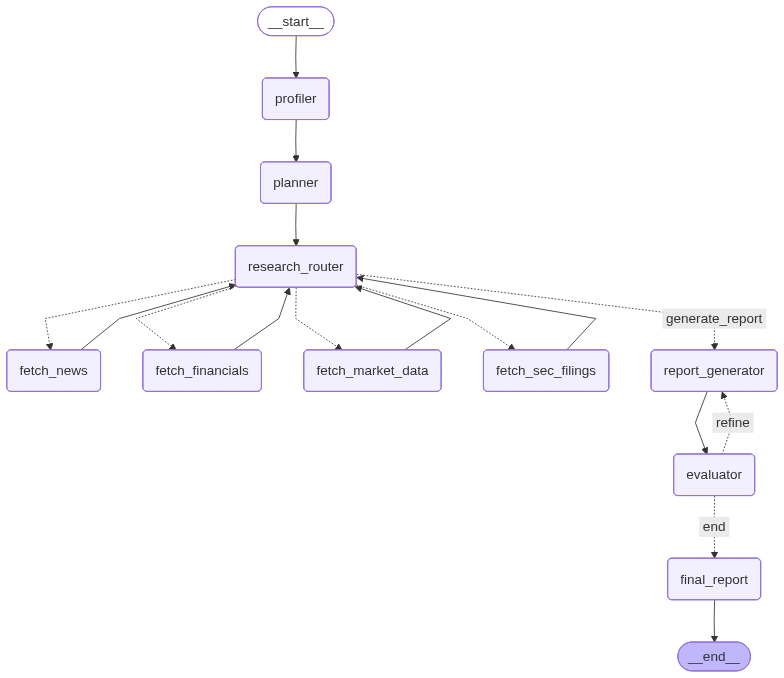

In [ ]:
app

This cell defines the `initial_state` dictionary with the stock symbol "NVDA" and then invokes the compiled `app` with this initial state. This starts the execution of the LangGraph workflow, running through the different agents and tools to generate a research report for NVIDIA. The final state of the graph execution is stored in the `final_state` variable. The stdout shows the progression through the different nodes in the graph.

In [ ]:
initial_state = {
    "stock_symbol": "NVDA"
}
final_state=app.invoke(initial_state)

---PROFILING COMPANY---
Profiler agent: Processing symbol NVDA
Profiler agent: Fetched profile for NVDA
---CREATING DYNAMIC PLAN---
Planner agent: Creating plan for NVDA based on profile.
Planner agent: Generated plan: ['fetch_news', 'fetch_sec_filings', 'fetch_financials', 'fetch_market_data']
--- AT RESEARCH ROUTING JUNCTION ---
---ROUTING---
---NEXT STEP: fetch_news---
---FETCHING NEWS---
News worker: Fetching news for NVDA
---CHAINING NEWS FOR NVDA (Ingested 5 articles)---
--- Preprocessed: Extracted texts from articles ---
--- Classified: 5 sentiments (e.g., bearish) ---
--- Extracted: Entities from 5 items ---
--- Summarized: Generated insights ---
News worker: Finished fetching news for NVDA. Updated plan: ['fetch_sec_filings', 'fetch_financials', 'fetch_market_data']
--- AT RESEARCH ROUTING JUNCTION ---
---ROUTING---
---NEXT STEP: fetch_sec_filings---
---FETCHING SEC FILINGS---
SEC worker: Fetching SEC filings for NVDA
SEC worker: Finished fetching SEC filings for NVDA. Updated

This cell displays the `final_state` dictionary after the LangGraph execution for "NVDA" is complete. This dictionary contains the final state of the research process, including the company profile, the retrieved data from the tools, the final generated report (in `draft_report` and `final_report`), and the evaluation details.

In [ ]:
final_state

{'stock_symbol': 'NVDA',
 'company_profile': {'sector': 'Technology',
  'industry': 'Semiconductors',
  'summary': 'NVIDIA Corporation, a computing infrastructure company, provides graphics and compute and networking solutions in the United States, Singapore, Taiwan, China, Hong Kong, and internationally. The Compute & Networking segment includes its Data Centre accelerated computing platforms and artificial intelligence solutions and software; networking; automotive platforms and autonomous and electric vehicle solutions; Jetson for robotics and other embedded platforms; and DGX Cloud computing services. The'},
 'research_plan': [],
 'retrieved_data': {'news': '--- Chained News Analysis for NVDA ---\n\n        **Sentiments (per article):**\n        [\n  {\n    "title": "China\'s Nvidia ban marks \'experimental phase\' of trade talks",\n    "sentiment": "bearish"\n  },\n  {\n    "title": "How to trade the AI boom beyond chips",\n    "sentiment": "neutral"\n  },\n  {\n    "title": "Inte

This cell displays the critique generated by the `evaluator_agent`. It shows the feedback provided on the `draft_report`, highlighting areas for improvement based on the evaluation criteria. In this case, the report was not approved due to issues with balance and data support, and specific actionable feedback is provided for refinement.

In [ ]:
final_state['critique']

'The report is **not balanced**.\n\nHere\'s the specific, actionable feedback for improvement:\n\n*   **Balance:** While the report mentions risks, the "Opportunities" and "Strengths" sections are significantly more detailed and positively framed than the "Weaknesses" and "Threats" sections. The overall tone leans heavily towards optimism, potentially downplaying the severity of the identified risks. To improve balance, consider:\n    *   **Quantifying Risks:** Where possible, try to provide some indication of the potential impact of identified risks. For example, instead of just stating "Geopolitical Risks and Export Controls," if there\'s publicly available information on the percentage of revenue lost or projected to be lost due to these controls, include it.\n    *   **Equal Weighting in SWOT:** Ensure that the "Weaknesses" and "Threats" sections are given comparable depth and detail to "Strengths" and "Opportunities."\n    *   **Nuance in Executive Summary and Conclusion:** While 

This cell displays the content of the `final_report` field from the `final_state` dictionary. This contains the final version of the investment research report for NVDA, which was generated and refined by the agent based on the collected data and evaluation feedback.

In [ ]:
final_state['final_report']

'## NVIDIA (NVDA) Investment Research Report\n\n**Date:** October 26, 2023\n\n**Prepared For:** Investment Committee\n\n**Prepared By:** [Your Name/Firm Name]\n\n---\n\n### Executive Summary\n\nNVIDIA Corporation (NVDA) stands at the forefront of the artificial intelligence (AI) revolution, a dominant force in the design and manufacturing of Graphics Processing Units (GPUs) that are critical for AI training and inference, as well as high-performance computing. The company has demonstrated exceptional financial performance, driven by unprecedented demand in its Data Center segment. However, significant geopolitical risks, intense competition, and supply chain complexities present considerable challenges. Despite these headwinds, the overwhelming analyst sentiment and the company\'s strategic positioning in a rapidly expanding market suggest continued growth potential for investors with a high-risk tolerance and a long-term perspective.\n\n---\n\n### Company Overview\n\nNVIDIA Corporatio

This cell displays the content of the `retrieved_data` field from the `final_state` dictionary. This dictionary contains all the data collected by the various worker nodes (news, SEC filings, financials, and market data) during the research process for NVDA.

In [ ]:
final_state['retrieved_data']

{'news': '--- Chained News Analysis for NVDA ---\n\n        **Sentiments (per article):**\n        [\n  {\n    "title": "China\'s Nvidia ban marks \'experimental phase\' of trade talks",\n    "sentiment": "bearish"\n  },\n  {\n    "title": "How to trade the AI boom beyond chips",\n    "sentiment": "neutral"\n  },\n  {\n    "title": "Intel \'needs\' Apple to invest like Nvidia & US government did",\n    "sentiment": "neutral"\n  },\n  {\n    "title": "Watch for this signal in Nvidia stock to capitalize on spring-loaded gains ahead",\n    "sentiment": "bullish"\n  },\n  {\n    "title": "Buy 5 Big Data Behemoths to Benefit From Enormous Market Opportunity",\n    "sentiment": "bullish"\n  }\n]\n\n        **Extracted Entities:**\n        [\n  {\n    "title": "China\'s Nvidia ban marks \'experimental phase\' of trade talks",\n    "entities": [\n      "China ban",\n      "Nvidia chips"\n    ]\n  },\n  {\n    "title": "How to trade the AI boom beyond chips",\n    "entities": [\n      "AI boom"